## HW3: Decision Tree, AdaBoost and Random Forest
In hw3, you need to implement decision tree, adaboost and random forest by using only numpy, then train your implemented model by the provided dataset and test the performance with testing data

Please note that only **NUMPY** can be used to implement your model, you will get no points by simply calling sklearn.tree.DecisionTreeClassifier

## Load data
The dataset is the Heart Disease Data Set from UCI Machine Learning Repository. It is a binary classifiation dataset, the label is stored in `target` column. **Please note that there exist categorical features which need to be [one-hot encoding](https://www.datacamp.com/community/tutorials/categorical-data) before fit into your model!**
See follow links for more information
https://archive.ics.uci.edu/ml/datasets/heart+Disease

In [125]:
import pandas as pd
import numpy as np
file_url = "http://storage.googleapis.com/download.tensorflow.org/data/heart.csv"
df = pd.read_csv(file_url)

# one-hot encode categorical values
categorical_features = ['cp', 'restecg', 'slope', 'thal']
for f in categorical_features:
    dummy_df = df[f]
    dummy_df = pd.get_dummies(dummy_df)
    dummy_df.rename(
        columns={k: f"{f}_{k}" for k in dummy_df.columns}, inplace=True)
    df.drop(f, axis=1, inplace=True)
    df = df.join(dummy_df)

# move "target" column to the last
target = df.pop("target")
df.insert(len(df.columns), "target", target)

train_idx = np.load('train_idx.npy')
test_idx = np.load('test_idx.npy')

train_df = df.iloc[train_idx]
test_df = df.iloc[test_idx]

# get numpy array
x_train, y_train = train_df.values[:, :-1], train_df['target'].values.astype(int)
x_test, y_test = test_df.values[:, :-1], test_df['target'].values.astype(int)


In [126]:
train_df.head()


,age,sex,trestbps,chol,fbs,thalach,exang,oldpeak,ca,cp_0,...,restecg_2,slope_1,slope_2,slope_3,thal_1,thal_2,thal_fixed,thal_normal,thal_reversible,target
136,54,1,192,283,0,195,0,0.0,1,0,...,1,1,0,0,0,0,0,0,1,0
232,58,0,170,225,1,146,1,2.8,2,0,...,1,0,1,0,0,0,1,0,0,1
233,56,1,130,221,0,163,0,0.0,0,0,...,1,1,0,0,0,0,0,0,1,0
184,46,1,120,249,0,144,0,0.8,0,0,...,1,1,0,0,0,0,0,0,1,0
84,55,0,135,250,0,161,0,1.4,0,0,...,1,0,1,0,0,0,0,1,0,0


## Question 1
Gini Index or Entropy is often used for measuring the “best” splitting of the data. Please compute the Entropy and Gini Index of provided data. Please use the formula from [page 5 of hw3 slides](https://docs.google.com/presentation/d/1kIe_-YZdemRMmr_3xDy-l0OS2EcLgDH7Uan14tlU5KE/edit#slide=id.gd542a5ff75_0_15)

In [127]:
def gini(sequence, weights=None):
    if weights is None:
        uniques, counts = np.unique(sequence, return_counts=True)
        p = (counts / len(sequence)) ** 2  # square of probabilities
        return 1.0 - np.sum(p)
    # implements sample weight
    else:
        gini = 1.0
        weights = weights / weights.sum()
        for c in np.unique(sequence):
            # calculate (weighted probability) ** 2 of label c
            gini -= np.sum(weights[sequence == c]) ** 2
        return gini


def entropy(sequence, weights=None):
    if weights is None:
        uniques, counts = np.unique(sequence, return_counts=True)
        p = counts / len(sequence)  # probabilities
        return -np.sum(p * np.log2(p))
    # implements sample weight
    else:
        entropy = 0
        weights = weights / weights.sum()
        for c in np.unique(sequence):
            # calculate weighted probability of label c
            tmp = np.sum(weights[sequence == c])
            entropy -= tmp * np.log2(tmp)
        return entropy


In [128]:
# 1 = class 1,
# 2 = class 2
data = np.array([1, 2, 1, 1, 1, 1, 2, 2, 1, 1, 2])


In [129]:
print("Gini of data is ", gini(data))


Gini of data is  0.4628099173553719


In [130]:
print("Entropy of data is ", entropy(data))


Entropy of data is  0.9456603046006401


## Question 2
Implement the Decision Tree algorithm (CART, Classification and Regression Trees) and trained the model by the given arguments, and print the accuracy score on the test data. You should implement two arguments for the Decision Tree algorithm
1. **criterion**: The function to measure the quality of a split. Your model should support `gini` for the Gini impurity and `entropy` for the information gain. 
2. **max_depth**: The maximum depth of the tree. If `max_depth=None`, then nodes are expanded until all leaves are pure. `max_depth=1` equals to split data once


In [131]:
class Node():
    def __init__(self, c_value, prediction):
        self.c_value = c_value
        self.prediction = prediction

        # be setted after training
        self.feature_idx = None
        self.threshold = None
        self.left = None
        self.right = None


class DecisionTree():
    def __init__(self, criterion='gini', max_depth=None, max_features=None):
        # set criterion function
        self.criterion = globals()[criterion]

        # set max_depth to "infinite" if not specified
        self.max_depth = max_depth if max_depth is not None else 2 ** 64
        self.max_features = max_features
        self.n_features = None

    def fit(self, x, y, sample_weight=None):
        self.n_features = x.shape[1]
        self.root = self.get_node(x, y, depth=0, sample_weight=sample_weight)
    
    def get_node(self, x, y, depth, sample_weight=None):
        '''
        inputs: data, label, current depth
        return: a node
        '''

        # select the major label as prediction 
        weighted_counts = np.bincount(y, weights=sample_weight) # sample_weight could be None if not specified
        prediction = np.argmax(weighted_counts)
            
        node = Node(
            c_value=self.criterion(y, sample_weight),
            prediction=prediction
        )

        # stop criterion
        if depth >= self.max_depth:
            return node

        node.feature_idx, node.threshold = self.best_split(
            x, y, sample_weight)

        # return when doesn't or can't be splitted
        if node.feature_idx is None:
            return node

        # < threshold is left group, >= threshold is right group
        left_idx = x[:, node.feature_idx] < node.threshold
        x_left, y_left = x[left_idx], y[left_idx]
        x_right, y_right = x[~left_idx], y[~left_idx]

        # get child nodes recursively
        # passes sample_weight if exist
        if sample_weight is not None:
            node.left = self.get_node(
                x_left, y_left, depth=depth + 1, sample_weight=sample_weight[left_idx])
            node.right = self.get_node(
                x_right, y_right, depth=depth + 1, sample_weight=sample_weight[~left_idx])
        else:
            node.left = self.get_node(x_left, y_left, depth=depth + 1)
            node.right = self.get_node(x_right, y_right, depth=depth + 1)

        return node

    def best_split(self, x, y, sample_weight):
        '''
        inputs: data and labels
        returns: feature_index and threshold for max information gain
        '''
        if len(y) <= 1:  # no need to split
            return None, None

        # "c" stands for criterion
        parent_c = self.criterion(y, sample_weight)
        best_ig = -2 ** 64  # "ig" stands for information gain
        best_idx, best_th = None, None

        # random select "max_features" of features to build node
        # (only used for building random forest)
        if self.max_features is not None:
            available_features = np.random.choice(
                np.arange(self.n_features), size=self.max_features, replace=False)
        else:
            available_features = np.arange(self.n_features)

        for idx in available_features:
            # sort data by this feature
            sort_idx = np.argsort(x[:, idx])

            # use average of i-1th & ith sorted value as candidates
            # will deal with duplicates afterwards
            thresholds = x[sort_idx, idx]
            labels = y[sort_idx]

            for pos in range(1, len(y)):
                # skip duplicates
                if thresholds[pos] == thresholds[pos - 1]:
                    continue

                # if sample_weight are given, use it to calculate criterion
                if sample_weight is not None:
                    sorted_sample_weight = sample_weight[sort_idx]
                    left_c = self.criterion(
                        labels[:pos], sorted_sample_weight[:pos])
                    right_c = self.criterion(
                        labels[pos:], sorted_sample_weight[pos:])
                else:
                    left_c = self.criterion(labels[:pos])
                    right_c = self.criterion(labels[pos:])

                # calculate weight average of left and right criterion
                child_c = (pos * left_c + (len(y) - pos) * right_c) / len(y)
                # calculates information gain
                ig = parent_c - child_c

                # record best information gain
                if ig > best_ig:
                    best_ig = ig
                    best_idx = idx
                    best_th = (thresholds[pos] + thresholds[pos - 1]) / 2

        return best_idx, best_th

    def predict(self, x):
        '''
        input: x with shape (n_samples, n_features)
        return: y with shape (n_samples, )
        '''

        def util(self, x):
            '''
            predicts a single sample
            '''
            cur_node = self.root
            while cur_node.left and cur_node.right:
                if x[cur_node.feature_idx] < cur_node.threshold:
                    cur_node = cur_node.left
                else:
                    cur_node = cur_node.right

            return cur_node.prediction

        return np.stack([util(self, single_x) for single_x in x])


### Question 2.1
Using `criterion=gini`, showing the accuracy score of test data by `max_depth=3` and `max_depth=10`, respectively.


In [132]:
from sklearn.metrics import accuracy_score


In [168]:
print("Q2.1")
clf_depth3 = DecisionTree(criterion='gini', max_depth=3)
clf_depth3.fit(x_train, y_train)
y_pred = clf_depth3.predict(x_test)
print("criterion=gini, max_depth=3:", accuracy_score(y_test, y_pred))

clf_depth10 = DecisionTree(criterion='gini', max_depth=10)
clf_depth10.fit(x_train, y_train)
y_pred = clf_depth10.predict(x_test)
print("criterion=gini, max_depth=10:", accuracy_score(y_test, y_pred))


Q2.1
criterion=gini, max_depth=3: 0.77
criterion=gini, max_depth=10: 0.72


### Question 2.2
Using `max_depth=3`, showing the accuracy score of test data by `criterion=gini` and `criterion=entropy`, respectively.


In [169]:
print("Q2.2")
clf_gini = DecisionTree(criterion='gini', max_depth=3)
clf_gini.fit(x_train, y_train)
y_pred = clf_gini.predict(x_test)
print("criterion=gini, max_depth=3:", accuracy_score(y_test, y_pred))

clf_entropy = DecisionTree(criterion='entropy', max_depth=3)
clf_entropy.fit(x_train, y_train)
y_pred = clf_entropy.predict(x_test)
print("criterion=entropy, max_depth=3:", accuracy_score(y_test, y_pred))


Q2.2
criterion=gini, max_depth=3: 0.77
criterion=entropy, max_depth=3: 0.79


- Note: Your decisition tree scores should over **0.7**. It may suffer from overfitting, if so, you can tune the hyperparameter such as `max_depth`
- Note: You should get the same results when re-building the model with the same arguments,  no need to prune the trees
- Hint: You can use the recursive method to build the nodes


## Question 3
Plot the [feature importance](https://sefiks.com/2020/04/06/feature-importance-in-decision-trees/) of your Decision Tree model. You can get the feature importance by counting the feature used for splitting data.

- You can simply plot the **counts of feature used** for building tree without normalize the importance. Take the figure below as example, outlook feature has been used for splitting for almost 50 times. Therefore, it has the largest importance

![image](https://i2.wp.com/sefiks.com/wp-content/uploads/2020/04/c45-fi-results.jpg?w=481&ssl=1)

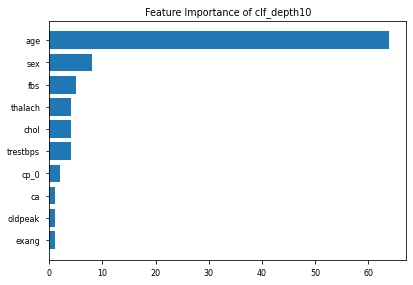

In [135]:
import matplotlib.pyplot as plt

# trace decision tree using bfs
# index of "counts" represents different feature index
queue = [clf_depth10.root]
counts = np.zeros(x_train.shape[1])
while len(queue) > 0:
    front = queue.pop(0)

    if front.feature_idx is not None:
        counts[front.feature_idx] += 1

    if front.left is not None:
        queue.append(front.left)
        queue.append(front.right)

# remove features with 0 counts
idx = counts > 0
counts = counts[idx]
ticks = df.columns[:-1][idx]

# sort counts
idx = np.argsort(counts)
counts = counts[idx]
ticks = df.columns[idx]

# plot
plt.style.use('seaborn-paper')
plt.figure()
plt.title("Feature Importance of clf_depth10")
plt.barh(range(len(counts)), counts)
plt.yticks(range(len(counts)), ticks)
plt.grid(False, axis='y')
plt.show()


## Question 4
implement the AdaBooest algorithm by using the CART you just implemented from question 2 as base learner. You should implement one arguments for the AdaBooest.
1. **n_estimators**: The maximum number of estimators at which boosting is terminated

In [136]:
class AdaBoost():
    def __init__(self, n_estimators, **kargs):
        self.n_estimators = n_estimators

        # be setted after training
        self.kargs = kargs
        self.clfs = None  # stores every weak classifier
        self.alphas = None  # stores every alpha value
        self.weights = None  # stores current sample_weight
        self.errors = None # stores error, for debugging

    def fit(self, X, y):
        self.alphas = []
        self.clfs = []
        self.errors = []
        self.weights = np.ones(len(y)) / len(y)  # initialize uniform weights

        for i in range(self.n_estimators):
            # train weak classifier with sample weight
            weak_clf = DecisionTree(**self.kargs)
            weak_clf.fit(X, y, sample_weight=self.weights)

            # compute error and alpha
            y_pred = weak_clf.predict(X)
            alpha = self.compute_alpha(y_pred, y)

            # record
            self.alphas.append(alpha)
            self.clfs.append(weak_clf)

            # update weight
            if i != self.n_estimators - 1:
                self.update_weights(y_pred, y, alpha)

    def predict(self, X):
        y_pred = np.zeros(len(X))
        for alpha, clf in zip(self.alphas, self.clfs):
            y_pred_weak = clf.predict(X)
            # quantize y_pred_weak to {0, 1}
            y_pred_weak = np.where(y_pred_weak == 1, 1, -1)
            y_pred += alpha * y_pred_weak

        # quantize y_pred to {0, 1}
        y_pred = np.where(y_pred > 0, 1, 0)
        return y_pred

    def compute_alpha(self, y_pred, y):
        # computes the weighted error
        error = np.sum(self.weights[y_pred != y])
        error = max(error, 1E-20)  # avoid divide by zero error
        self.errors.append(error)
        # computes new alpha based on error
        return 0.5 * np.log((1.0 - error) / error) # np.log is ln

    def update_weights(self, y_pred, y, alpha):
        # update sample weights
        y_dot_hx = np.where(y == y_pred, 1, -1) # 1 if y = h(x), -1 if y != h(x)
        new_weights = self.weights * np.exp(-alpha * y_dot_hx)
        new_weights /= new_weights.sum()  # normalization
        self.weights = new_weights


### Question 4.1
Show the accuracy score of test data by `n_estimators=10` and `n_estimators=100`, respectively.


In [172]:
print("Q4.1")
ada_clf_10 = AdaBoost(n_estimators=10, max_depth=3)
ada_clf_10.fit(x_train, y_train)
y_pred = ada_clf_10.predict(x_test)
print(f"n_estimators=10, max_depth=3: {accuracy_score(y_pred, y_test)}")

ada_clf_100 = AdaBoost(n_estimators=100, max_depth=3)
ada_clf_100.fit(x_train, y_train)
y_pred = ada_clf_100.predict(x_test)
print(f"n_estimators=100, max_depth=3: {accuracy_score(y_pred, y_test)}")

Q4.1
n_estimators=10, max_depth=3: 0.79
n_estimators=100, max_depth=3: 0.78


## Question 5
implement the Random Forest algorithm by using the CART you just implemented from question 2. You should implement three arguments for the Random Forest.

1. **n_estimators**: The number of trees in the forest. 
2. **max_features**: The number of random select features to consider when looking for the best split
3. **bootstrap**: Whether bootstrap samples are used when building tree


In [138]:
class RandomForest():
    def __init__(self, n_estimators, max_features, boostrap=True, **kargs):
        self.n_estimators = n_estimators
        self.boostrap = boostrap
        self.kargs = kargs  # stores (criterion, max_depth)
        self.kargs['max_features'] = int(
            max_features) if max_features is not None else None

        # be setted after training
        self.clfs = []  # stores every tree

    def fit(self, X, y):
        raw_X, raw_y = X, y
        for _ in range(self.n_estimators):
            if self.boostrap:
                # peform bootstrap if sepcified
                X, y = self.get_bootstrap(raw_X, raw_y)
            clf = DecisionTree(**self.kargs)  # passes kargs
            clf.fit(X, y)
            self.clfs.append(clf)

    def get_bootstrap(self, x, y):
        # implement bootstrap with np.random.choice, default value for replace is True
        idx = np.random.choice(np.arange(len(y)), size=len(y))
        return x[idx], y[idx]

    def predict(self, X):
        # calculate mean of every clf
        y_pred = np.mean([clf.predict(X) for clf in self.clfs], axis=0)

        # quantize y_pred to {0, 1}
        y_pred = np.where(y_pred >= 0.5, 1, 0)

        return y_pred


### Question 5.1
Using `criterion=gini`, `max_depth=None`, `max_features=sqrt(n_features)`, showing the accuracy score of test data by `n_estimators=10` and `n_estimators=100`, respectively.


In [179]:
print("Q5.1")
clf_10tree = RandomForest(
    n_estimators=10, max_features=np.sqrt(x_train.shape[1]))
clf_10tree.fit(x_train, y_train)
y_pred = clf_10tree.predict(x_test)
print(f"n_estimators=10: {accuracy_score(y_pred, y_test)}")

clf_100tree = RandomForest(
    n_estimators=100, max_features=np.sqrt(x_train.shape[1]))
clf_100tree.fit(x_train, y_train)
y_pred = clf_100tree.predict(x_test)
print(f"n_estimators=100: {accuracy_score(y_pred, y_test)}")


Q5.1
n_estimators=10: 0.72
n_estimators=100: 0.77


### Question 5.2
Using `criterion=gini`, `max_depth=None`, `n_estimators=10`, showing the accuracy score of test data by `max_features=sqrt(n_features)` and `max_features=n_features`, respectively.


In [174]:
print("Q5.2")
clf_random_features = RandomForest(
    n_estimators=10, max_features=np.sqrt(x_train.shape[1]))
clf_random_features.fit(x_train, y_train)
y_pred = clf_random_features.predict(x_test)
print(f"max_features=sqrt(n_features): {accuracy_score(y_pred, y_test)}")

clf_all_features = RandomForest(n_estimators=10, max_features=x_train.shape[1])
clf_all_features.fit(x_train, y_train)
y_pred = clf_all_features.predict(x_test)
print(f"max_features=n_features: {accuracy_score(y_pred, y_test)}")


Q5.2
max_features=sqrt(n_features): 0.77
max_features=n_features: 0.74


- Note: Use majority votes to get the final prediction, you may get slightly different results when re-building the random forest model

### Question 6.
Try you best to get highest test accuracy score by 
- Feature engineering
- Hyperparameter tuning
- Implement any other ensemble methods, such as gradient boosting. Please note that you cannot call any package. Also, only ensemble method can be used. Neural network method is not allowed to used.

In [141]:
file_url = "http://storage.googleapis.com/download.tensorflow.org/data/heart.csv"
df = pd.read_csv(file_url)

# remove catagorical features (since its not important, IMO)
categorical_features = ['cp', 'restecg', 'slope', 'thal']
for f in categorical_features:
    df.pop(f)

target = df.pop("target")
df.insert(len(df.columns), "target", target)

train_idx = np.load('train_idx.npy')
test_idx = np.load('test_idx.npy')

train_df = df.iloc[train_idx]
test_df = df.iloc[test_idx]

# get numpy array
x_train, y_train = train_df.values[:, :-1], train_df.values[:, -1].astype(int)
x_test, y_test = test_df.values[:, :-1], test_df.values[:, -1].astype(int)


In [209]:
your_model = RandomForest(
    n_estimators=100,
    max_features=np.sqrt(x_train.shape[1]),
    max_depth=1
)
your_model.fit(x_train, y_train)
y_pred = your_model.predict(x_test)

print(f'Test-set accuarcy score: {accuracy_score(y_test, y_pred)}')


Test-set accuarcy score: 0.87


## Supplementary
If you have trouble to implement this homework, TA strongly recommend watching [this video](https://www.youtube.com/watch?v=LDRbO9a6XPU), which explains Decision Tree model clearly. But don't copy code from any resources, try to finish this homework by yourself! 